## Hello, this is the start for the research paper en epilepsy seizure prediction using deep learning techniques
### Enrique Posada Lozano   A01700711
<a href="https://www.google.com">Visit Repository</a>
<a href="https://www.google.com">Read Report / Research Paper</a>


In [1]:
# import required libraries
import os
import numpy as np 
import tensorflow as tf
import mne
import matplotlib.pyplot as plot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import re
import time
# import pandas as pd

In [2]:
print("Current TensorFlow Version \t:\t",tf.version.VERSION)
print("tf Version >= 2.0 \t\t?\t",(tf.version.VERSION) >= '2.0')
# Consider this is made using tensorflow version >=2.0

Current TensorFlow Version 	:	 2.1.0
tf Version >= 2.0 		?	 True


## Steps
### 1. Separar los datos de seizure del resto
### 2. Segmentar (Sacar las Ventanas de 30 min)
### 3. Clasificar (Tomar el ULTIMO SEGMENTO como pre-ictal, el resto como inter-ictal) 
### 4. Repetir PERO ir concatenando lo obtenido de cada conjunto de ventanas

# Proceso/Pasos a seguir:
## 1. HALLAR DATOS U OCURRENCIA DE SEIZURE 
## 2. TOMAR LA VENTANA DE PREICTAL DE 30 MIN ANTES DEL SEIZURE
    2A. TOMAR COMO VENTANA INTER-ICTAL AQUELLOS DATOS 30 MIN PERO CON UN OFFSET DEL PREICTAL DE 1 HORA O 30 MIN CON UN IF-STATMENT
## 3. AL SACAR VENTANAS, A LA PAR SE CLASIFICA (EJ: SACAR VENTANA PRE-ICTAL Y ALLI MISMO HACER UN LABEL DE DIMENSION CORRECTA DE PRE-ICTAL)
### 3A. AL SACAR INFO DE TODO UN PACIENTE, SACAR SUBVENTANAS (PRIMERO ES PROBAR SOLO CON VENTANAS DE 30 MIN, SI FUNCIONA ENTONCES PROCEDER CON SUBDIVIDIR DATOS) 

## Definition of CONSTANTS

In [3]:
# DATA CONSTANTS
_60SECONDS = 60
SAMPLING_RATE = 256 # Sampling Rate in Hz FREQUENCY RATE
PREICTAL_WINDOW = 5 # duration in minutes of the main window for sampling preictal data (original of 30 min)
INTERICTAL_WINDOW = 30 # duration in minutes of the main window for sampling interictal data
# For now, interictal and preictal windows should be the same in order to avoid issues qith having segments of different sizes
INTERICTAL_OFFSET = 60*_60SECONDS*SAMPLING_RATE # duration in minutes for the offset between preictal and interictal segments, as well as seizure end and interictal period after (1hr) (minutesx(number of samples in 60 seconds))
# SEGMENTS TO USE
PREICTAL_SEGMENT = PREICTAL_WINDOW*_60SECONDS*SAMPLING_RATE # (e.g: with 30 min x 60 seconds x 256 Hz, gives 460,800 as segment duration)
INTERICTAL_SEGMENT = INTERICTAL_WINDOW*_60SECONDS*SAMPLING_RATE # (e.g: with 30 min x 60 seconds x 256 Hz, gives 460,800 as segment duration)
SUBWINDOW = 60 # duration in seconds for the getting subsegments from windows (60 default)
SUBSEGMENT = SUBWINDOW*SAMPLING_RATE # (e.g: with 60 * 256, gives 15,360 as segment duration) this'll be the same for ALL WINDOWS
# NUM_CHANNELS = 18
CHANNELS = ["FP1-F7","F7-T7","T7-P7","P7-O1","FP1-F3","F3-C3","C3-P3","P3-O1","FP2-F4","F4-C4","C4-P4","P4-O2","FP2-F8","F8-T8","T8-P8-0","P8-O2","FZ-CZ","CZ-PZ"]
# CHANNELS = ["FP1-F7"] # testing only with one channel

NUM_CHANNELS = len(CHANNELS)
# path for dataset summary files
PATH = "/Users/quiqueposada/Downloads/chb-mit-scalp-eeg-database-1.0.0/" # absolute path

# directory to save data
directory = ('_'+str(PREICTAL_WINDOW)+'minPreictal')+('/_'+str(SUBWINDOW)+'s/')
SAVEPATH = '/Users/quiqueposada/Documents/Sem.Feb-Jun/Tesina/Code/' # single quotes can handle white space


# Colors used for pretty printing
_WARNING_COLOR = "\033[93m"
_SUCCESS_COLOR = "\033[92m"
_ERROR_COLOR = "\033[91m"
_NORMAL_COLOR = "\033[0m"

#### Plot EEG seizure data as demonstration 

SHAPE	 (18, 921600)
Creating RawArray with float64 data, n_channels=18, n_times=921600
    Range : 0 ... 921599 =      0.000 ...  3599.996 secs
Ready.


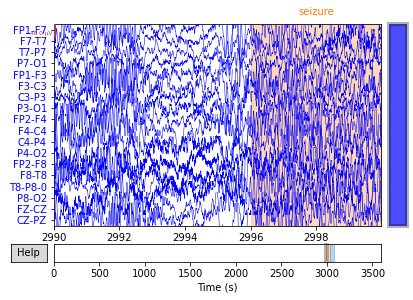

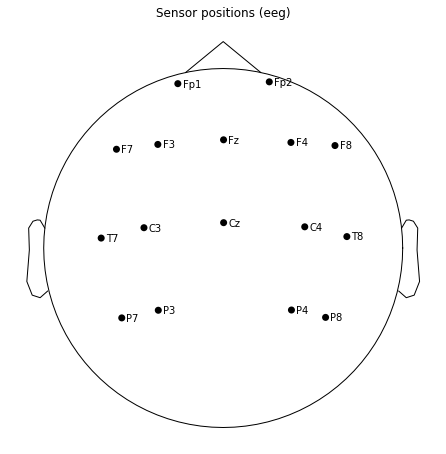

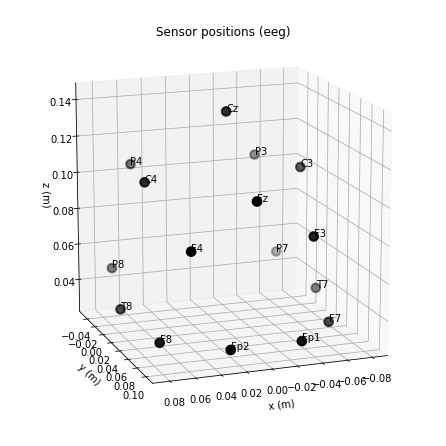

In [5]:

TESTPATH = "/Users/quiqueposada/Downloads/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_03.edf"
TESTCHANNELS = ["FP1-F7","F7-T7","T7-P7","P7-O1","FP1-F3","F3-C3","C3-P3","P3-O1","FP2-F4","F4-C4","C4-P4","P4-O2","FP2-F8","F8-T8","T8-P8-0","P8-O2","FZ-CZ","CZ-PZ"]
NUM_TESTCHANNELS = len(TESTCHANNELS)

raw = mne.io.read_raw_edf(TESTPATH,verbose="ERROR")
d = raw.get_data(TESTCHANNELS)
print("SHAPE\t",d.shape)
info = mne.create_info(ch_names=TESTCHANNELS, sfreq=256, ch_types=['eeg']*d.shape[0] )

# create raw mne object
raw = mne.io.RawArray(d, info)
raw.set_annotations(mne.Annotations(onset=[2996,3036],duration=40,description=['seizure','']))
raw.plot(start=2990,color='b',)

replace_dict = {}
drop_list = []
# for the channel names in the data...
for channel_name in raw.info['ch_names']:
    # get the name to change too
    name_change = re.findall('\w+',channel_name)[0].title()
    # check if it is already in the change list
    if name_change in list(replace_dict.values()):
        drop_list.append(channel_name)
    else:
        # if its not already there get the origional name and what we want to 
        # change it to
        replace_dict[channel_name] = name_change

# drop the ones that would be repeats
raw.drop_channels(drop_list)
# rename the TESTchannels
raw.rename_channels(replace_dict)
# set the standard montage
raw.set_montage('standard_1020')

raw.plot_sensors(kind='topomap', show_names=True, to_sphere=True)
fig = raw.plot_sensors(kind='3d', show_names=True, show=False)
fig = fig.gca().view_init(azim=70, elev=15)
plot.show()

## Definition of functions

In [5]:
def getData(filePath,patientId):
    """
        Obtains features and labels from a given patient in the CHB-MIT dataset

        Input: 
        filePath    -> path to a patient's recording summary .txt
        patient     -> name or ID of a patient (e.g: 'chb01') 

        Output:
        returns the features and labels from a .edf recording, windowing data that is either recognized as pre-ictal or inter-ictal
    """
    patient1StartTime = time.time()
    # features, labels contains the desired features and labels for 1 patient's EEG data
    features = []
    labels = []
    # real ones down here
    # subsegments = []
    subsegments = np.array([])
    subsegmentList = []
    subsegmentLabels = []
    global TOTAL_MINUTES
    with open(filePath, "r") as txtFile:
        # for line in txtFile:
        line = txtFile.readline() # get first line
        while (line):
            if line.startswith("File Name: "):
                fileName = line.split(": ")[1][:-1] # obtains only the file name, removing last character of new line
                if patientId != "chb24":
                    # Skips 2 lines (which indicate EEG recording times) to num. of seizures
                    txtFile.readline()
                    txtFile.readline()
                # NOTE: patient 'chb24' has a different structure summary file than the rest
                line = txtFile.readline() # line containing number of seizures
                numSeizures = int(line.split(": ")[1]) # converts number of seizures to int
                if numSeizures > 0:
                    # temporary break/continue for only checking on normal files
                    # continue

                    # PRINTS CURRENT SEIZURE FILE EVALUATED
                    # print("Currently on file \t"+_ERROR_COLOR+fileName+_NORMAL_COLOR)
                    # print("# of Seizures :", numSeizures)

                    # filePath = "/Users/quiqueposada/Downloads/chb-mit-scalp-eeg-database-1.0.0/"+patientId+"/"+fileName
                    filePath = PATH+patientId+"/"+fileName
                    rawData = mne.io.read_raw_edf(filePath,verbose="ERROR") # only prints information regarding ERRORS
                    try:
                        data = rawData.get_data(CHANNELS)
                    except ValueError:
                        print("\n\n"+_WARNING_COLOR+"File "+fileName+" does not contain required channels"+_NORMAL_COLOR)
                        print(_WARNING_COLOR+"File '"+fileName+"' Skipped\n"+_NORMAL_COLOR)
                        continue
                    # nonSeizureArr = np.empty([rawData.get_data()[0].size,18]) # declare empty array of dimensions in recording
                    # nonSeizureArr = data

                    if data.shape[1] < PREICTAL_SEGMENT:
                        # print(_WARNING_COLOR+"Recording '"+fileName+"' lasts less than PREICTAL SEGMENT defined of "+str(PREICTAL/SAMPLING_RATE/60)+" min"+_NORMAL_COLOR)
                        print(_WARNING_COLOR+"Recording '"+fileName+"' lasts less than PREICTAL SEGMENT defined of "+str(PREICTAL_WINDOW)+" min"+_NORMAL_COLOR)
                        print(_WARNING_COLOR+"\tFile '"+fileName+"' skipped"+_NORMAL_COLOR)
                        # means there was no way of obtaining data for the predefined duration of the preictal window
                        continue

                    if data.shape[0] != NUM_CHANNELS:
                        print(_WARNING_COLOR+"Recording '"+fileName+"' does not contain all "+str(NUM_CHANNELS)+" required channels"+_NORMAL_COLOR)
                        print("CHANNELS "+_ERROR_COLOR+str(len(rawData.ch_names))+_NORMAL_COLOR)
                        print(_WARNING_COLOR+"\tFile '"+fileName+"' skipped (For now...)"+_NORMAL_COLOR)
                        continue
                    
                    seizureSet = set() # set containing the start and end of each seizure in order to avoid having ictal data in the dataset
                    for seizure in range(numSeizures):
                        # for loop that goes through each seizure, extracting windows for building the dataset to train the model 

                        # print("Number of seizure \t\t", seizure+1)
                        seizureStart = txtFile.readline()
                        seizureEnd = txtFile.readline()
                        # print("Starts at: "+seizureStart[:-1]+"\nEnds at: "+seizureEnd[:-1])
                        seizureStart = int(re.split(": | seconds",seizureStart)[1])*SAMPLING_RATE
                        seizureEnd = int(re.split(": | seconds",seizureEnd)[1])*SAMPLING_RATE

                        seizureSet.add((seizureStart,seizureEnd)) # add seizure times to set for control of data

                        # nonSeizureArr = np.delete(nonSeizureArr,np.r_[:,(seizureStart*SAMPLING_RATE):(seizureEnd*SAMPLING_RATE)],axis=1)
                        # pointsExcluded += data[:,(seizureStart*SAMPLING_RATE):(seizureEnd*SAMPLING_RATE)].shape[1]
                        # print("Data Is Correct? ", (nonSeizureArr.shape[1]+pointsExcluded) == data.shape[1])
                        # print("Seizure is in segment\t",(seizureStart))
                        # print(data.shape)


                        # REAL Implementation here
                        # NOTE this approach does not guarantee each array to be of the same size, just gets as much data to what is desired
                        # which is 30 min of preictal, 30 min before and after seizure for interictal with an offset of 30 min from important windows 
                        # print("\nREAL ONE STARTS HERE")

                        # Points are always saved in order to avoid reusing data when multiple seizures can overlap other interictal windows
                        preictalStart = 0
                        preictalEnd = 0
                        interictalBeforeStart = 0
                        interictalBeforeEnd = 0
                        interictalAfterStart = 0
                        interictalAfterEnd = 0
                        offsetBefore = 0
                        offsetAfter = 0

                        # print("Seizure starts at\t",seizureStart)
                        # print("Seizure is before 30 min span ?? \t",seizureStart < SEGMENT) # means preictal should take from seizure start down to 0 [0:start]

                        if seizureStart > PREICTAL_SEGMENT :
                            preictalStart = seizureStart - PREICTAL_SEGMENT
                            preictalEnd = seizureStart
                        else :
                            preictalStart = 0 # just used as a reference, please optimize later
                            preictalEnd = seizureStart
                        
                        # print("Preictal Start\t",preictalStart)
                        # print("Preictal End\t",preictalEnd)
                        # print("Can SUBSEGMENT 60s preictalStart ?\t",preictalStart >= SUBSEGMENT or preictalStart == 0)
                        # print("Can SUBSEGMENT 60s preictalEnd ?\t",preictalEnd >= SUBSEGMENT)

                        # offsetBefore = preictalStart - SEGMENT
                        offsetBefore = preictalStart - INTERICTAL_OFFSET
                        if offsetBefore > 0 :
                            if (offsetBefore - INTERICTAL_SEGMENT) > 0:
                                interictalBeforeStart = offsetBefore - INTERICTAL_SEGMENT
                                interictalBeforeEnd = offsetBefore
                            else :
                                interictalBeforeStart = 0
                                interictalBeforeEnd = offsetBefore
                        # print("InterictalBefore Start\t",interictalBeforeStart)
                        # print("InterictalBefore End\t",interictalBeforeEnd)

                        # offsetAfter = seizureEnd + SEGMENT
                        offsetAfter = seizureEnd + INTERICTAL_OFFSET
                        if offsetAfter < data.shape[1] :
                            if offsetAfter + INTERICTAL_SEGMENT < data.shape[1] :
                                interictalAfterStart = offsetAfter
                                interictalAfterEnd = offsetAfter + INTERICTAL_SEGMENT
                            else:
                                interictalAfterStart = offsetAfter
                                interictalAfterEnd = data.shape[1]
                        # print("InterictalAfter Start\t",interictalAfterStart)
                        # print("InterictalAfter End\t",interictalAfterEnd)

                        # AFTER GETTING ALL RANGES of POINTS, get the data and assign labels to the array of preictal or interictal labels
                        # TODO AFTER GETTING ALL DATA, NOW ONE CAN CHECK FOR NOT HAVING DATA COLLIDING WITH ANY OF THE SEIZURES
                        for seizureTimes in seizureSet:
                            # for preictal check
                            if preictalStart > seizureTimes[0] and preictalStart <= seizureTimes[1]:
                                # print("seizure start\t",seizureTimes[0])
                                # print("seizure end\t",seizureTimes[1])
                                # print("preictal start\t",preictalStart)
                                # print("preictal end\t",preictalEnd)
                                preictalStart = seizureTimes[1] # preictal starts just as seizure ends (for data of upcoming seizure)
                                # print("\n\n___AFTER CHANGES___")
                                # print("preictal start\t",preictalStart)
                                # print("preictal end\t",preictalEnd)
                                print(_WARNING_COLOR+"ICTAL DATA IS OVERLAPPING PREICTAL"+_NORMAL_COLOR)
                                print(_WARNING_COLOR+"Segment modified"+_NORMAL_COLOR)
                                # raise Exception("ICTAL DATA IS OVERLAPPING for PREICTAL !!!!!!")
                            if preictalEnd > seizureTimes[0] and preictalEnd <= seizureTimes[1]:
                                raise Exception("ICTAL DATA IS OVERLAPPING for PREICTAL!!!!!!")
                                preictalEnd = seizureTimes[0]
                            # for interictal before
                                # interictal before start and end
                            if interictalBeforeStart > seizureTimes[0] and interictalBeforeStart <= seizureTimes[1]:
                                interictalBeforeStart = seizureTimes[1]
                                raise Exception("ICTAL DATA IS OVERLAPPING for for INTERICTAL BEFORE !!!!!!")
                            if interictalBeforeEnd > seizureTimes[0] and interictalBeforeEnd <= seizureTimes[1]:
                                raise Exception("ICTAL DATA IS OVERLAPPING for for INTERICTAL BEFORE !!!!!!")
                                interictalBeforeEnd = seizureTimes[0]
                            # for interictal after
                                # interictal before start and end   
                            if interictalAfterStart > seizureTimes[0] and interictalAfterStart <= seizureTimes[1]:
                                interictalAfterStart = seizureTimes[1]
                                raise Exception("ICTAL DATA IS OVERLAPPING for INTERICTAL AFTER !!!!!!")
                            if interictalAfterEnd > seizureTimes[0] and interictalAfterEnd <= seizureTimes[1]:
                                raise Exception("ICTAL DATA IS OVERLAPPING for INTERICTAL AFTER !!!!!!")
                                interictalAfterEnd = seizureTimes[0]
                            

                        preIctalSegment = data[:,preictalStart:preictalEnd]
                        # Append a class of 1 as preictal
                        features.append(preIctalSegment)
                        labels.append(1)

                        if not (interictalBeforeStart == 0 and interictalBeforeEnd == 0) :
                            features.append(data[:,interictalBeforeStart:interictalBeforeEnd])
                            labels.append(0)
                            # print("Can SUBSEGMENT 60s interictalBeforeStart ?\t",interictalBeforeStart >= SUBSEGMENT or interictalBeforeStart == 0)
                            # print("Can SUBSEGMENT 60s interictalBeforeEnd ?\t",interictalBeforeEnd >= SUBSEGMENT)
                        if not (interictalAfterStart == 0 and interictalAfterEnd == 0) :
                            features.append(data[:,interictalAfterStart:interictalAfterEnd])
                            labels.append(0)
                            # print("Can SUBSEGMENT 60s InterictalAfterStart ?\t",interictalAfterStart >= SUBSEGMENT)
                            # print("Can SUBSEGMENT 60s interictalAfterEnd ?\t",interictalAfterEnd >= SUBSEGMENT)
                        # print("Features\t",features)
                        # print("Labels\t",labels)
                        
                        # REAL implementation ends here


                    # print("Great, you have data for '"+_ERROR_COLOR+fileName+_NORMAL_COLOR+"'\n")
                    # FINISHED PROCESSING FILE

                else:
                    # pass
                    # continue # skips data
                    # here you can randomly select a file, and take interictal data
                    # Or the 2nd option is to just take data, and later on undersample or oversample the data
                    
                    # and at the end, data is converted to a single array from which to work on
                    # the point of this is to at least work with 10,000 samples of data to train upon, using the strategies declared
                    # 50% probability of using file data or skipping
                    # if np.random.choice([0,1]) == 0: continue 
                    # continue
                    # if np.random.rand() > 0.4: continue 
                    if np.random.rand() > 0.1: continue 
                        # file is skipped, using random probability, else obtains data
                    filePath = PATH+patientId+"/"+fileName
                    print(fileName+" to be used")
                    rawData = mne.io.read_raw_edf(filePath,verbose="ERROR") # only prints information regarding ERRORS
                    try:
                        data = rawData.get_data(CHANNELS)
                    except ValueError:
                        print("\n\n"+_WARNING_COLOR+"File "+fileName+" does not contain required channels"+_NORMAL_COLOR)
                        print(_WARNING_COLOR+"File '"+fileName+"' Skipped\n"+_NORMAL_COLOR)
                        continue
                    if data.shape[0] != NUM_CHANNELS:
                        print(_WARNING_COLOR+"Recording '"+fileName+"' does not contain all "+str(NUM_CHANNELS)+" required channels"+_NORMAL_COLOR)
                        print(_WARNING_COLOR+"\tFile '"+fileName+"' skipped (For now...)"+_NORMAL_COLOR)
                        continue
                    segments = None
                    try:
                        segments = data.reshape(-1,NUM_CHANNELS,SUBSEGMENT)
                    except ValueError:
                        # features[index]
                        # segments = features[index][:,:int((features[index].shape[1]/SAMPLING_RATE)//60)*60*SAMPLING_RATE].reshape(-1,NUM_CHANNELS,SUBSEGMENT)
                        segments = data[:,:int((data.shape[1]/SAMPLING_RATE)//60)*60*SAMPLING_RATE].reshape(-1,NUM_CHANNELS,SUBSEGMENT)
                        # print("DOING SOMETHING DIFFERENT!!!!!!! interictal/normal data")
                    # and just add to features
                    # print("SEG ",segments[:,:5])
                    # x = np.where(np.array(segments) == 0)[0]
                    # print("IS 0? ",(segments == 0)[:5]) #if the first 5 are, probably the rest are as well
                    TOTAL_MINUTES += ((data.shape[1]/SAMPLING_RATE)//60)
                    subsegmentList.append(segments)
                    labelSegments = np.zeros(len(segments))
                    subsegmentLabels += (labelSegments.tolist())
                    # subsegmentLabels.append(labelSegments)

                    # print("NEWLINE!\t",line)
                    # print("no seizure")
            line = txtFile.readline()

        # APPROACH FOR USING DATA OF SAME SIZE (always append to a list, then you can convert all data to desired shape)
        

            # print("POSSIBLE WINDOWS\t",subwindowSize)
            # print(features[index].shape)
            # if subwindowSize == 30 : # means only windows of 60 seconds are taken only (30min)
            # if subwindowSize == 15 : # means only windows of 60 seconds are taken only (15min)
            # if subwindowSize == 10 : # means only windows of 60 seconds are taken only (15min)
            # THIS CONDITIONAL APPROACH ALLOWS OBTAINING DATA USSING DIFFERENT PREDEFINED PREICTAL AND INTERICTAL WINDOWS INSTEAD OF USING THE SAME SIZE
            # # PREV APPROACH
            # if labels[index] == 0:
            #     # interictal segment
            #     if subwindowSize == INTERICTAL_WINDOW:
            #         segments = np.array_split(features[index],subwindowSize,axis=1)
            #         # segments = np.array_split(features[index],30,axis=1)
            #         # Axis is modified in order to subsegment in time but not separate channels
            #         subsegments += segments
            #         # subsegments = np.append(subsegments,segments)
            #         labelSegments = np.ones(len(segments)) if labels[index] == 1 else np.zeros(len(segments))
            #         # print("LABEL LEN\t",len(labelSegments.tolist()))
            #         subsegmentLabels += (labelSegments.tolist())
            # else:
            #     # preictal segment
            #     if subwindowSize == PREICTAL_WINDOW : # means only windows of 60 seconds are taken only (15min)
            #         # TOTAL_MINUTES += ((features[index].shape[1]/SAMPLING_RATE)//60)
            #         segments = np.array_split(features[index],subwindowSize,axis=1)
            #         # segments = np.array_split(features[index],30,axis=1)
            #         # Axis is modified in order to subsegment in time but not separate channels
            #         subsegments += segments
            #         # subsegments = np.append(subsegments,segments)
            #         labelSegments = np.ones(len(segments)) if labels[index] == 1 else np.zeros(len(segments))
            #         # print("LABEL LEN\t",len(labelSegments.tolist()))
            #         subsegmentLabels += (labelSegments.tolist())

            # if subwindowSize == PREICTAL_WINDOW : # means only windows of 60 seconds are taken only (15min)
            #     # TOTAL_MINUTES += ((features[index].shape[1]/SAMPLING_RATE)//60)
            #     segments = np.array_split(features[index],subwindowSize,axis=1)
            #     # segments = np.array_split(features[index],30,axis=1)
            #     # Axis is modified in order to subsegment in time but not separate channels
            #     subsegments += segments
            #     # subsegments = np.append(subsegments,segments)
            #     labelSegments = np.ones(len(segments)) if labels[index] == 1 else np.zeros(len(segments))
            #     # print("LABEL LEN\t",len(labelSegments.tolist()))
            #     subsegmentLabels += (labelSegments.tolist())
            #     # print("TRADITIONAL APPROACH\t",subsegments[0].shape)
            # else:
            #     subsegments.append(features[index])
            #     subsegmentLabels.append(labels[index]) 


        for index in range(len(labels)):
            subwindowSize = features[index].shape[1]//(SUBSEGMENT) # obtains num. of windows for a given segment
            # print("Segment of "+str(subwindowSize)+" minutes")

            # print("ORIGINAL SHAPE\t",features[index].shape)
            # print("SAMPLE DURATION IN MIN\t",(features[index].shape[1]/SAMPLING_RATE)//60)
            TOTAL_MINUTES += ((features[index].shape[1]/SAMPLING_RATE)//60) # used in case of using different window sizes like below

            #  NEW APPROACH BY RESHAPING !!! THIS CAN OBTAIN NEW SAMPLES
            # this new approach aims to use data segmented with less time than whats defined by reshaping and removing what is not of 1 min
            if (features[index].shape[1] > SUBSEGMENT): # greater than 60 seconds, or defined duration for subsegment windows
                # print(True)
                # print("\nDURATION\t",features[index].shape[1]/256/60)
                # print("DURATION FLOORED\t",(features[index].shape[1]/SAMPLING_RATE)//60)
                # print("NEW SEGMENT FLOORED\t",((features[index].shape[1]/SAMPLING_RATE)//60)*60*SAMPLING_RATE)
                segments = None
                try:
                    segments = features[index].reshape(-1,NUM_CHANNELS,SUBSEGMENT)
                except ValueError:
                    # features[index]
                    # segments = features[index][:,:int((features[index].shape[1]/SAMPLING_RATE)//60)*60*SAMPLING_RATE].reshape(-1,NUM_CHANNELS,SUBSEGMENT)
                    segments = features[index][:,:int((features[index].shape[1]/SAMPLING_RATE)//60)*60*SAMPLING_RATE].reshape(-1,NUM_CHANNELS,SUBSEGMENT)
                    # NOTE PERHAPS RESHAPING TO THE TIMESTEPS MAY BE DESIRABLE IN ORDER TO OBTAIN ONLY SECONDS PER SEGMENT INSETAD OF ONLY OBTAINS 60 SECOND SAMPLES
                    # TODO: THIS MIGHT NOT BE THE WAY TO ROUND AND CALCULATE, THIS IS UN NECESARY AND NEEDS REFACTORING
                    # TO CHECK THIS, JUST PRINT THE SHAPE AND SEE HOW MUCH IT CHANGES WITH THE OPERATIONS DONE ON TOP
                    # reshapes data to the nearest minute, instead of having 5.2 min of data, only 5 min of data
                subsegmentList.append(segments)
                labelSegments = np.ones(len(segments)) if labels[index] == 1 else np.zeros(len(segments))
                subsegmentLabels += (labelSegments.tolist())
                # subsegmentLabels.append(labelSegments)

                    # print("possible?\t",features[index][:,:int((features[index].shape[1]/SAMPLING_RATE)//60)*60*SAMPLING_RATE].reshape(-1,NUM_CHANNELS,SUBSEGMENT).shape)
                # print(_ERROR_COLOR+"OHHHHMO"+_NORMAL_COLOR)
                # print("ARR BEFORE SHAPE\t",subsegments.shape)
                # subsegments = np.concatenate((subsegments,segments),axis=0) if subsegments.size > 0 else segments # avoids np errors by joining arrays only if the array is not empty

        print("Time of Execution\t"+str(round(time.time()-patient1StartTime,2))+" seconds")
        subsegments = np.vstack(subsegmentList)
        # subsegmentLabels
        # subsegments = joinSegments(subsegmentList)
            # NOTE TODO PERHAPS YOU CAN USE THE FUNC JOIN SEGMENTS INSTEAD OF VSTACK FOR PERFORMANCE IMPROVEMENT
        # for i in subsegments:
        #     # print("SEG ",i[:,:5])
        #     i = i.reshape(-1,12,NUM_CHANNELS*5*SAMPLING_RATE)
        #     print("SHAPE\t",i.shape)
        #     print("DATA ",i[:5])
        #     x = np.where(np.array(i) == 0)[0]
        #     print("IS 0? ",(x.size > 0)) #if the first 5 are, probably the rest are as well
        #     if (x.size > 0) :
        #         raise Exception("OH NO ",i.shape)
        #     print("\n\n\n")
            # subsegmentList.append(segments)
            # labelSegments = np.ones(len(segments)) if labels[index] == 1 else np.zeros(len(segments))
            # subsegmentLabels += (labelSegments.tolist())
        # subsegments = np.vstack((allDataFeatures,subsegmentList)) if allDataFeatures != [] else np.vstack(subsegmentList)
        print(_ERROR_COLOR+"Finished passing patient\t"+patientId+_NORMAL_COLOR)
        print("\n\n")
        return subsegments, subsegmentLabels

In [6]:
def joinSegments(features):
    """
        Made as a substitute for np.vstack() since vstack() brings a memory allocation issue, crashing the kernel
        Creates an empty numpy array of the desired size, and fills each index with its SUBSEGMENT in correct order to the labels
    """
    size = 0
    # allows to append large chunks of an array by first knowing the size of the array (which is total minutes in this case, and then filling an empty array of the desired size)
    for feature in features:
        size += feature.shape[0]
    # arr = np.zeros((int(TOTAL_MINUTES),NUM_CHANNELS,SUBSEGMENT))
    arr = np.zeros((size,NUM_CHANNELS,SUBSEGMENT))
    print("SHAPE\t",arr.shape)
    i = 0

    split = len(features)//4 # split into 4 chunks to fill

    for index,feature in enumerate(features):
        print("INDEX\t"+str(index)+" with shape\t"+str(feature.shape))
        # print("Overall data shape so far\t",)
        st = time.time()
        for subFeature in feature:
            # print("\n\n\n")
            # x = np.where(subFeature == 0)[0].size
            # print(_NORMAL_COLOR+"subFeature has 0? "+_WARNING_COLOR,x)
            # arr[subindex,:] = subFeature
            # TODO test with this
            # arr[subindex] = subFeature
            arr[i,:] = subFeature
            # print("subfeature \t",subFeature.shape)
            # print("in arr \t",arr[i].shape)
            i += 1
            # print("i val ",i)
            # print(_NORMAL_COLOR+"subFeature "+_WARNING_COLOR,subFeature)
            # x = np.where(arr[index] == 0)[0].size
            # print(_NORMAL_COLOR+"arr has 0? "+_ERROR_COLOR,x)
            # print(_NORMAL_COLOR+"in arr "+_ERROR_COLOR,arr[subindex,1:5])
            # print(_NORMAL_COLOR)
            # print("SUBSEGMENT DONE",end="\r")
        print("\tProcess took "+str(round(time.time()-st))+" seconds\n")
    print("np array size :\t",arr.shape)
    return arr

In [7]:
def balanceClasses(features,labels,sampling):
    """
        Balances the interictal and preictal classes by looking for the class with least amount of data, and randomly choosing segments from the other class in order to balance the class dataset
        Input:
            Receieves the preictal and interictal indexes \n
            sampling receives either "undersampling" or "oversampling" as parameter in order to determine the process to execute
        Output:
            returns a numpy array containing the indexes of both preictal and interictal data
    """
    samplingParams = set(("undersampling","oversampling"))
    if not sampling in samplingParams: raise ValueError("sampling PARAM must be either 'undersampling' or 'oversampling'")
    interictal_indexes = np.array(np.where(labels == 0))[0]
    preictal_indexes = np.array(np.where(labels == 1))[0]
    print("___Original Data Length___")
    print("Preictal \t:\t",preictal_indexes.shape)
    print("Interictal \t:\t",interictal_indexes.shape)
    print("\n")
    if sampling == "undersampling":
        if len(preictal_indexes) > len(interictal_indexes):
            # if there are more preictal segments, randomly choose segments to balance dataset
            preictal_indexes = np.random.choice(preictal_indexes,len(interictal_indexes),replace=False)
        else:
            # randomly choose interictal segments to balance the dataset
            interictal_indexes = np.random.choice(interictal_indexes,len(preictal_indexes),replace=False)
    else:
        if len(preictal_indexes) < len(interictal_indexes):
            # if there are less preictal segments, randomly choose segments to balance dataset with more, repeated preictal data
            preictal_indexes = np.random.choice(preictal_indexes,len(interictal_indexes),replace=True)
        else:
            # randomly choose interictal segments to balance the dataset
            interictal_indexes = np.random.choice(interictal_indexes,len(preictal_indexes),replace=True)
    print("\n___Modified Shape___")
    print("Preictal \t:\t",preictal_indexes.shape)
    print("Interictal \t:\t",interictal_indexes.shape)
    indexes = np.concatenate((preictal_indexes,interictal_indexes)) # shuffles indexes in order to not have data in an organized manner
    # print(indexes)
    # print("Shuffling")
    np.random.shuffle(indexes)
    # print(indexes)
    # raise Exception(" NONE, just finished")
    print("Returning indexed data")
    startTime = time.time()
    indexedFeatures = features[indexes]
    print("Features obtained took "+str(round(time.time()-startTime))+" seconds")
    indexedLabels = labels[indexes]
    print("Class Label Count\t",np.unique(indexedLabels,return_counts=True))
    # print("\n\n")
    return indexedFeatures, indexedLabels

## Extracts the EEG segments from all patients with recorded seizures

In [8]:

# allDataFeatures = np.array([]) # list containing an array of data for each patient
# allDataLabels = []
# totalFeatures = 0
# startingTime = time.time()

# TOTAL_MINUTES = 0

# for patientId in range(1,25):
#     timeStart = time.time()
#     patient = "chb0"+str(patientId) if patientId < 10 else "chb"+str(patientId)
#     filePath = PATH+patient+"/"+patient+"-summary.txt"
#     patientFeatures, patientLabels = getData(filePath,patient)
#     totalFeatures += len(patientFeatures)
#     # allDataFeatures += patientFeatures
#     allDataFeatures = np.concatenate((allDataFeatures,patientFeatures),axis=0) if allDataFeatures.size > 0 else patientFeatures    
#     allDataLabels += patientLabels
#     print("Total\t",len(allDataFeatures))
#     print("Time taken for "+patient+"\t:\t"+str(round(time.time()-timeStart))+" seconds")
# # print("TOTAL # of Windows (Segments)\t",totalFeatures)

# allDataLabels = np.array(allDataLabels)

# print("\nAmount of features:\t",len(allDataFeatures))
# print("\nTotal time\t:\t"+str(TOTAL_MINUTES)+" minutes of data")

# print("Finished Getting all Data")
# print("Process took\t"+str(round(time.time()-startingTime))+" seconds")

# # allDataLabels = np.array(allDataLabels)
# # allDataFeatures = np.array(allDataFeatures)
# # print("TOTAL # of Features (Segments)\t",allDataFeatures.shape)
# # print("TOTAL # of Labels (Segments)\t",allDataLabels.shape)

In [9]:
"""
    this approach increases perfromance by stacking all EEG segments per patient after having all the data, instead of doing the operation inside the loop
    obtains in a list all features per patient
"""
allDataFeatures = [] # list containing an array of data for each patient
allDataLabels = []
# totalFeatures = 0
startingTime = time.time()

TOTAL_MINUTES = 0

for patientId in range(1,25):
    timeStart = time.time()
    patient = "chb0"+str(patientId) if patientId < 10 else "chb"+str(patientId)
    filePath = PATH+patient+"/"+patient+"-summary.txt"
    patientFeatures, patientLabels = getData(filePath,patient)
    # totalFeatures += len(patientFeatures)
    allDataFeatures.append(patientFeatures)

    # allDataFeatures = np.concatenate((allDataFeatures,patientFeatures),axis=0) if allDataFeatures.size > 0 else patientFeatures    
    allDataLabels += patientLabels
    # allDataLabels.append(patientLabels)
    # print("Total\t",len(allDataFeatures))
    print("Total\t",allDataFeatures[patientId-1].shape)
    print("Time taken for "+patient+"\t:\t"+str(round(time.time()-timeStart))+" seconds")
    print("\n\n")
# print("TOTAL # of Windows (Segments)\t",totalFeatures)

allDataLabels = np.array(allDataLabels)

print("\nAmount of features:\t",len(allDataFeatures))
print("\nTotal time\t:\t"+str(TOTAL_MINUTES)+" minutes of data")

print("Finished Getting all Data")
print("Process took\t"+str(round(time.time()-startingTime))+" seconds")

chb01_08.edf to be used
chb01_19.edf to be used
chb01_22.edf to be used
chb01_37.edf to be used
Time of Execution	2.38 seconds
Finished passing patient	chb01



Total	 (275, 18, 15360)
Time taken for chb01	:	3 seconds



chb02_18.edf to be used
chb02_20.edf to be used
chb02_24.edf to be used
chb02_25.edf to be used
Time of Execution	1.39 seconds
Finished passing patient	chb02



Total	 (252, 18, 15360)
Time taken for chb02	:	2 seconds



chb03_21.edf to be used
chb03_38.edf to be used
Time of Execution	1.94 seconds
Finished passing patient	chb03



Total	 (155, 18, 15360)
Time taken for chb03	:	2 seconds



chb04_18.edf to be used
chb04_31.edf to be used
chb04_32.edf to be used
Time of Execution	5.52 seconds
Finished passing patient	chb04



Total	 (890, 18, 15360)
Time taken for chb04	:	7 seconds



chb05_10.edf to be used
Time of Execution	1.38 seconds
Finished passing patient	chb05



Total	 (85, 18, 15360)
Time taken for chb05	:	2 seconds



chb06_15.edf to be used
Time of Executio

In [ ]:
for index,patient in enumerate(allDataFeatures):
    print("Feature\t",patient.shape)
    # print("Label\t",allDataLabels[index].shape)
    print("\n")

In [ ]:
for index,patient in enumerate(allDataFeatures):
    print("Feature\t",patient.shape)
    # print("Label\t",allDataLabels[index].shape)
    print("\n")

In [ ]:
for i,x in enumerate(allDataLabels):
    # x=np.array(x)
    # print(x.shape)
    # Obtains a count of total classes in dataset, used in order to know how to balance the classes
    uniqueLabels, labelCounts = np.unique(np.array(x),return_counts=True)
    print("Unique Classes\t\t",uniqueLabels)
    print("Counts per Class\t",labelCounts)
    print("that was patient "+str(i+1),"\n\n")

In [ ]:
# for i,x in enumerate(allDataLabels):
    # x=np.array(x)
    # print(x.shape)
    # Obtains a count of total classes in dataset, used in order to know how to balance the classes
    # uniqueLabels, labelCounts = np.unique(np.array(x),return_counts=True)
    # print("that was patient "+str(i+1)+"n\n")
uniqueLabels, labelCounts = np.unique(np.array(allDataLabels),return_counts=True)
print("Unique Classes\t\t",uniqueLabels)
print("Counts per Class\t",labelCounts)


In [ ]:
# balance classes if interictal is much greater than preictal in patient data 
for i,x in enumerate(allDataLabels):
    print("patient "+str(i+1),"\n\n")
    # x=np.array(x)
    # print(x.shape)
    # Obtains a count of total classes in dataset, used in order to know how to balance the classes
    uniqueLabels, labelCounts = np.unique(np.array(x),return_counts=True)
    print("Unique Classes\t\t",uniqueLabels)
    print("Counts per Class\t",labelCounts)

    if labelCounts[0] > labelCounts[1]:
        # balance by undersampling
        allDataFeatures[i],allDataLabels[i] = balanceClasses(allDataFeatures[i],np.array(allDataLabels[i]),sampling="undersampling")

    uniqueLabels, labelCounts = np.unique(np.array(x),return_counts=True)
    print("Unique Classes\t\t",uniqueLabels)
    print("Counts per Class\t",labelCounts)
    print("that was patient "+str(i+1),"\n\n")

In [10]:
# dataFeatures = allDataFeatures[5]
# dataLabels = np.array(allDataLabels[5])
allDataLabels.shape

(21769,)

### Join All Features into a single numpy array

In [ ]:
# # allDataFeatures = joinSegments(allDataFeatures)
# dataFeatures = joinSegments(allDataFeatures)
# # c = joinSegments(allDataFeatures)
# # print(c.shape)
# print("features shape",allDataFeatures.shape)

In [10]:
# allDataFeatures = joinSegments(allDataFeatures)
allDataFeatures = joinSegments(allDataFeatures)
# c = joinSegments(allDataFeatures)
# print(c.shape)
print("features shape",allDataFeatures.shape)

SHAPE	 (6756, 18, 15360)
INDEX	0 with shape	(275, 18, 15360)
	Process took 2 seconds

INDEX	1 with shape	(252, 18, 15360)
	Process took 2 seconds

INDEX	2 with shape	(155, 18, 15360)
	Process took 2 seconds

INDEX	3 with shape	(890, 18, 15360)
	Process took 11 seconds

INDEX	4 with shape	(85, 18, 15360)
	Process took 1 seconds

INDEX	5 with shape	(673, 18, 15360)
	Process took 7 seconds

INDEX	6 with shape	(332, 18, 15360)
	Process took 3 seconds

INDEX	7 with shape	(205, 18, 15360)
	Process took 2 seconds

INDEX	8 with shape	(638, 18, 15360)
	Process took 7 seconds

INDEX	9 with shape	(283, 18, 15360)
	Process took 3 seconds

INDEX	10 with shape	(254, 18, 15360)
	Process took 4 seconds

INDEX	11 with shape	(253, 18, 15360)
	Process took 3 seconds

INDEX	12 with shape	(110, 18, 15360)
	Process took 1 seconds

INDEX	13 with shape	(160, 18, 15360)
	Process took 2 seconds

INDEX	14 with shape	(278, 18, 15360)
	Process took 3 seconds

INDEX	15 with shape	(38, 18, 15360)
	Process took 0 sec

In [ ]:
# old approach, would take long on too much data, would have memory allocation issues, works by using the joinSegments function 
dataFeatures = np.vstack(allDataFeatures)

### Save only Features and labels
#### NOTE: the desired approach is by saving the train, val and test files, in order to start with the models faster without consuming many resources from this notebook

In [ ]:
# allDataFeatures.shape
# SAVE NP ARRAY
# _10minPreictal/
np.save('data/'+directory+'data_features',allDataFeatures)
print("Features Saved")
np.save('data/'+directory+'data_labels',allDataLabels)
print("Data saved")

In [ ]:
allDataLabels.shape

In [ ]:
# allDataFeatures.flatten().shape

#### Used when labels are grouped per patient

In [ ]:
# arr = []
for index,item in enumerate(allDataLabels):
    allDataLabels[index] = np.array(item)
    print(allDataLabels[index].shape)
# allDataLabels = np.array(arr)

In [ ]:
allDataLabels = np.hstack(allDataLabels)

In [ ]:
allDataLabels

## Load data from npy files (*if possible*)

In [ ]:
allDataFeatures = np.load("data/data_features.npy")
allDataLabels = np.load("data/data_labels.npy")
print("done")
print("Data feature shape :\t",allDataFeatures.shape)
print("Data label shape :\t",allDataLabels.shape)

In [ ]:
# # PREVIOUS APPROACH
# print(len(allDataFeatures))
# for x in range(len(allDataFeatures)):
#     print("Patient "+str(x+1)+" shape\t",allDataFeatures[x].shape)
# startTime=time.time()
# allDataFeatures = np.vstack(allDataFeatures)
# print(allDataFeatures.shape)
# print("Took\t"+str(round(time.time()-startTime))+" seconds")

## Extract data from only <u>One</u> patient
# Data from one patient can be retreived from the all data features

In [ ]:
# # allDataFeatures = np.array([])
# allDataFeatures = []
# allDataLabels = []
# startingTime = time.time()

# # global TOTAL_MINUTES
# TOTAL_MINUTES = 0

# # variable indicating the patient id number (1-24) from whom to fetch data
# # patientId = 6 # 6 is chosen since it contains a good amount of EEG data
# patientId = 13
# patient = "chb0"+str(patientId) if patientId < 10 else "chb"+str(patientId)
# filePath = PATH+patient+"/"+patient+"-summary.txt"
# patientFeatures, patientLabels = getData(filePath,patient)
# # allDataFeatures += patientFeatures
# # allDataFeatures = np.concatenate((allDataFeatures,patientFeatures),axis=0) if allDataFeatures.size > 0 else patientFeatures
# allDataFeatures.append(patientFeatures)
# allDataLabels += patientLabels

# allDataFeatures = np.vstack(allDataFeatures)
# allDataLabels = np.array(allDataLabels)

# print("\nAmount of features:\t",len(allDataFeatures))
# print("\nTotal time\t:\t"+str(TOTAL_MINUTES)+" minutes of data")

# print("\nFinished getting data from patient")
# print("Process took\t"+str(round(time.time()-startingTime))+" seconds")

In [ ]:
print("Shape of single feature of "+str(SUBWINDOW)+" seconds",(allDataFeatures[0].shape))

### Convert data to numpy arrays

In [11]:
# allDataLabels = np.array(allDataLabels)
# dataFeatures = np.array(allDataFeatures) # converts an array (useful for when not balancing classes)
# dataLabels = allDataLabels
print("Feature Shape\t",allDataFeatures.shape)
print("Label Shape\t",allDataLabels.shape)

Feature Shape	 (6756, 18, 15360)
Label Shape	 (6756,)


In [12]:
# # THIS IS JUST A TEST, AND IS REALLY NOT NECESSARY FOR NOW!!!!
# startTime = time.time()
# _3DTest = np.array(allDataFeatures)
# # allDataLabels = np.array(allDataLabels)
# print("Feature Shape\t",_3DTest.shape)
# print("Label Shape\t",allDataLabels.shape)
# print("Converting list ot 3D Array took\t"+str(round(time.time()-startTime))+" seconds")
# #  ### This step is nor really necessary for now since balancing the dataset takes care of doing this process

## Divide / Balance Data in order for having 50% of preictal data and 50% of interictal data

In [13]:
# Obtains a count of total classes in dataset, used in order to know how to balance the classes
uniqueLabels, labelCounts = np.unique(np.array(allDataLabels),return_counts=True)
print("Unique Classes\t\t",uniqueLabels)
print("Counts per Class\t",labelCounts)

Unique Classes		 [0. 1.]
Counts per Class	 [5874  882]


In [14]:

allDataFeatures,allDataLabels = balanceClasses(allDataFeatures,allDataLabels,sampling="undersampling")

___Original Data Length___
Preictal 	:	 (882,)
Interictal 	:	 (5874,)



___Modified Shape___
Preictal 	:	 (882,)
Interictal 	:	 (882,)
Returning indexed data
Features obtained took 19 seconds
Class Label Count	 (array([0., 1.]), array([882, 882]))


## Resampling Data 
Consists of under-sampling which is removing samples from the majority class 
    (in this case, the preictal class) referenced from <a href="https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets">Here</a>

In [15]:
# labelArr = np.array(allDataLabels)
interictalIndexes = np.array(np.where(np.array(allDataLabels) == 0))[0]
preictalIndexes = np.array(np.where(np.array(allDataLabels) == 1))[0]
# preictalIndexes = preictalIndexes[0]
# print(type(preictalIndexes[0]))
print("# of preictal segments \t\t:\t",preictalIndexes.shape)
print("# of interictal segments \t:\t",interictalIndexes.shape)
print("Real Shape\t\t\t:\t",allDataLabels.shape)
# print(allDataLabels[(interictalIndexes)])

# of preictal segments 		:	 (882,)
# of interictal segments 	:	 (882,)
Real Shape			:	 (1764,)


In [ ]:
# not really necessary, just used to show it works
# x = np.where(np.array(allDataLabels)==0)[0]
# print(x)
# print(np.array(allDataLabels)[x])

In [ ]:
# allDataLabels[4227]

In [ ]:
# preictalIndexes[0]

In [ ]:
# np.random.choice(interictalIndexes,len(preictalIndexes)).shape
# interictalIndexes
# labelCounts
# balanceClasses(preictalIndexes,interictalIndexes,sampling="oversampling")
# indexes = balanceClasses(preictalIndexes,interictalIndexes,sampling="oversampling")

# dataFeatures, dataLabels = balanceClasses(preictalIndexes,interictalIndexes,sampling="oversampling")

In [ ]:
# allDataLabels.shape
# print(indexes.shape)

In [ ]:
# preictalIndexes = np.random.choice(np.array(np.where(np.array(allDataLabels) == 1))[0], labelCounts[0],replace=False) 
# # undersampling by getting the same data as the class with least amount of data
# # else:
#     # there is more preictal data than interictal
# # print(preictalIndexes)
# print(preictalIndexes.shape[0]*2)
# print(np.concatenate((preictalIndexes,interictalIndexes)).shape) # original, returns literally the original data shape
# print(np.concatenate((preictalIndexes,interictalIndexes)).shape)
# indexes = np.concatenate((preictalIndexes,interictalIndexes))
# print("indexes of data we care about ",np.unique(allDataLabels[indexes],return_counts=True))
# # print(allDataLabels[testing])
# # Now YOU HAVE TO EXCLUDE UNNECESARY DATA

In [ ]:
# # obtains the balanced dataset
# # startTime = time.time()
# # dataFeatures = np.array(allDataFeatures)[indexes]
# # try:
#     # dataFeatures = allDataFeatures[indexes]
#     # dataLabels = allDataLabels[indexes]
# # INDEXES IS NOT USED ANYMORE
# # except:
# # print(_WARNING_COLOR+"indexes not yet used"+_NORMAL_COLOR)
# # when the dataset has not yet used indexes to balance the dataset
# dataFeatures = allDataFeatures
# dataLabels = allDataLabels
# print("Feature Shape\t",dataFeatures.shape)
# print("Label Shape\t",dataLabels.shape)
# print("Balancing dataset took\t"+str(round(time.time()-startTime))+" seconds")

In [16]:
# used when not balancing the dataset 
dataFeatures = allDataFeatures
dataLabels = allDataLabels

In [17]:
print("Feature Shape\t",dataFeatures.shape)
print("Label Shape\t",dataLabels.shape)
print("ClassCount\t",np.unique(dataLabels,return_counts=True))

Feature Shape	 (1764, 18, 15360)
Label Shape	 (1764,)
ClassCount	 (array([0., 1.]), array([882, 882]))


# Reshapes 60s segments into 12 5s segments (Subdivides data further into 5 second segments from 60 second data segments)
### 12 represents the number of timesteps
### 18 x 256 x 5 flattens features into desired shape
### THIS IS ONLY USED FOR RNN architectures

In [18]:
# TESTING RESHAPE (this is the one to use)
# DURATION_PER_TIMESTEP = 5 # in seconds
DURATION_PER_TIMESTEP = 5
TIMESTEP_SIZE = SUBWINDOW//DURATION_PER_TIMESTEP # SUBWINDOW/DURATION_PER_TIMESTEP
dataFeatures = dataFeatures.reshape(-1,TIMESTEP_SIZE,NUM_CHANNELS*DURATION_PER_TIMESTEP*SAMPLING_RATE)
# dataFeatures = dataFeatures.reshape(-1,12,NUM_CHANNELS*5*SAMPLING_RATE)

In [20]:
dataFeatures.shape

(1764, 12, 23040)

### Save data already reshaped

In [29]:
# np.save('data/'+directory+'_'+str(TIMESTEP_SIZE)+'ts/'+'train_features',dataFeatures)
# np.save('data/'+directory+'_'+str(TIMESTEP_SIZE)+'ts/'+'train_labels',dataLabels)

In [30]:
# # Reshapes dataset (leaves shape in form features,timesteps)
# # subDivision_seconds = 5
# dataFeatures = dataFeatures.reshape(-1,NUM_CHANNELS*5*SAMPLING_RATE,12)
# print("DataFeature shape\t",dataFeatures.shape)
# print("DataLabel shape\t\t",dataLabels.shape)

### <span>Flattens 3D Array (<u>Only used for ANN</u>, cell above reshapes data for the RNN network)</span>

In [16]:
dataFeatures = dataFeatures.reshape(dataFeatures.shape[0],-1) # crucial for the model to work

In [17]:
dataFeatures.shape

(10678, 276480)

# Convert Data Features into a 3D numpy Array ( \t  <u>Perhaps ignore for now</u>)

In [ ]:
# # Converts the list of numpy arrays into a 3D numpy array (process takes around 50 seconds with approx. 5000 samples)
# _3Dfeatures = np.empty((len(allDataFeatures),allDataFeatures[0].shape[0],allDataFeatures[0].shape[1]))
# checkTime = time.time()
# for index in range(len(allDataFeatures)):
#     _3Dfeatures[index] = allDataFeatures[index]
# print(_3Dfeatures.shape)
# print("Took "+str(time.time()-checkTime)+" seconds")

In [ ]:
# # print(type(allDataLabels))
# # print(len(allDataLabels))
# """
#     features are now presented as a 3D array, having each block be a 60s recording of 18 channels across 15360 points (60s of time * SAMPLING_RATE)
# """
# print(_3Dfeatures.shape)

## Flatten the matrix into a 2D array of vectors size (allDataFeatures,(flattenedVector))
### THIS IS ONLY USED FOR ANN

In [ ]:
# flattenedFeatures = _3Dfeatures.reshape(len(allDataFeatures),-1) # crucial for the model to work

In [ ]:
# _3Dfeatures.reshape(len(allDataFeatures),-1).shape

# Split Data into Train/Test Subsets
#### Data is split using 95-5 % rule for train and test data while validation takes only 5% of the training dataset
## NOTE: validation is taken from the test set in order to make it faster and avoid the broken connection to kernel

In [ ]:
# # x_Train,x_Test,y_Train,y_Test = train_test_split(flattenedFeatures,allDataLabels,train_size=0.9,random_state=40)
# startTime = time.time()
# # using flattened dataFeatures
# # x_Train,x_Test,y_Train,y_Test = train_test_split(flattenedFeatures,dataLabels,train_size=0.9,random_state=40,stratify=dataLabels)
# # using reshaped dataFeatures
#     # Split into train and test Dataset
# x_Train,x_Test,y_Train,y_Test = train_test_split(dataFeatures,dataLabels,train_size=0.90,random_state=40,stratify=dataLabels)
# print("___Data Shape before validation___")
# print("Train Features Shape\t\t",x_Train.shape)
# print("Train Labels Shape\t\t",y_Train.shape)
# print("Test Features Shape\t\t",x_Test.shape)
# print("Test Labels Shape\t\t",y_Test.shape)
# print("\n\n")

# print("\nProcess took "+str(round(time.time()-startTime))+" seconds")
# # without balancing classes
# # x_Train,x_Test,y_Train,y_Test = train_test_split(dataFeatures,dataLabels,train_size=0.9,random_state=40)

# """
#     random_state is used temporarily in order to obtain consistent results
#     training size is set to be of 90% of the data, having 10% for testing the model
#     the stratify arg takes care of balancing tha class label dataset, so there is a consistent division of data for the model (training with 50% interictal        and 50% preictal)
# """

In [21]:
# x_Train,x_Test,y_Train,y_Test = train_test_split(flattenedFeatures,allDataLabels,train_size=0.9,random_state=40)
startTime = time.time()
# using flattened dataFeatures
# x_Train,x_Test,y_Train,y_Test = train_test_split(flattenedFeatures,dataLabels,train_size=0.9,random_state=40,stratify=dataLabels)
# using reshaped dataFeatures
    # Split into train and test Dataset
x_Train,x_Test,y_Train,y_Test = train_test_split(dataFeatures,dataLabels,train_size=0.90,stratify=dataLabels)
print("___Data Shape before validation___")
print("Train Features Shape\t\t",x_Train.shape)
print("Train Labels Shape\t\t",y_Train.shape)
print("Test Features Shape\t\t",x_Test.shape)
print("Test Labels Shape\t\t",y_Test.shape)
print("\n\n")

print("Training Class Label Count\t",np.unique(np.array(y_Train),return_counts=True))
print("Testing Class Label Count\t",np.unique(np.array(y_Test),return_counts=True))

print("\nProcess took "+str(round(time.time()-startTime))+" seconds")
# without balancing classes
# x_Train,x_Test,y_Train,y_Test = train_test_split(dataFeatures,dataLabels,train_size=0.9,random_state=40)

"""
    random_state is used temporarily in order to obtain consistent results
    training size is set to be of 90% of the data, having 10% for testing the model
    the stratify arg takes care of balancing tha class label dataset, so there is a consistent division of data for the model (training with 50% interictal        and 50% preictal)
"""

___Data Shape before validation___
Train Features Shape		 (1587, 12, 23040)
Train Labels Shape		 (1587,)
Test Features Shape		 (177, 12, 23040)
Test Labels Shape		 (177,)



Training Class Label Count	 (array([0., 1.]), array([793, 794]))
Testing Class Label Count	 (array([0., 1.]), array([89, 88]))

Process took 12 seconds


'\n    random_state is used temporarily in order to obtain consistent results\n    training size is set to be of 90% of the data, having 10% for testing the model\n    the stratify arg takes care of balancing tha class label dataset, so there is a consistent division of data for the model (training with 50% interictal        and 50% preictal)\n'

In [ ]:
# # Memory efficient way for splitting a large dataset into train/val/test
# # df = pd.DataFrame(dataFeatures) # convert to dataframe
# x_indexes = np.array(list(range(len(allDataFeatures)))) # obtain a list of all indexes from which to split
# print(len(x_indexes))


# startTime = time.time()
#     # Split into train and test Dataset
# # x_Train,x_Test,y_Train,y_Test = train_test_split(x_indexes,dataLabels,train_size=0.90,random_state=40,stratify=dataLabels)
# train_test_split(x_indexes,dataLabels,train_size=0.90,random_state=40,stratify=dataLabels)
# print("___Data Shape before validation___")
# print("Train Features Shape\t\t",x_Train.shape)
# print("Train Labels Shape\t\t",y_Train.shape)
# print("Test Features Shape\t\t",x_Test.shape)
# print("Test Labels Shape\t\t",y_Test.shape)
# print("\n\n")

# print("Training Class Label Count\t",np.unique(np.array(y_Train),return_counts=True))
# print("Testing Class Label Count\t",np.unique(np.array(y_Test),return_counts=True))

# print("\nProcess took "+str(round(time.time()-startTime))+" seconds")

In [ ]:
train = dataFeatures[x_Train]
print("DONE!")
print(x_Train[:5])
print(dataLabels[x_Train[:5]])

In [ ]:
# k = np.where(allDataFeatures == 0)[0]
# print(k.shape)
# print("k ",k.size)
# for i,index in enumerate(k):
#     print(allDataFeatures[index])
#     if i == 450:
#         break
# for i,index in enumerate(allDataFeatures):
#     print("Is 0 ",index[:5])
    # if i == 450:
    #     break

In [22]:
"""
    Obtain more data by only oversampling the training data, leaving duplicates out of the dataset when testing
"""

x_Train,y_Train = balanceClasses(x_Train,y_Train,sampling="oversampling")

___Original Data Length___
Preictal 	:	 (7743,)
Interictal 	:	 (11849,)



___Modified Shape___
Preictal 	:	 (7743,)
Interictal 	:	 (7743,)
Returning indexed data


In [32]:

# y_Train.shape
print("Class Label Count\t",np.unique(y_Train,return_counts=True))

Class Label Count	 (array([0., 1.]), array([4582, 3915]))


In [22]:
"""
    The validation dataset is taken from here
"""
startTime = time.time()
    # Split into train and validation Datasets using 10% for validation and the rest for training
# x_Train,x_Val,y_Train,y_Val = train_test_split(x_Train,y_Train,test_size=0.05,random_state=40,stratify=y_Train)
x_Test,x_Val,y_Test,y_Val = train_test_split(x_Test,y_Test,test_size=0.50,stratify=y_Test) # takes half of 10%, making 90%-5%-5%
print("___Data Shape after validation___")
print("Train Features Shape\t\t",x_Train.shape)
print("Train Labels Shape\t\t",y_Train.shape)
print("Validation Features Shape\t",x_Val.shape)
print("Validation Labels Shape\t\t",y_Val.shape)

print("Test Features Shape\t\t",x_Test.shape)
print("Test Labels Shape\t\t",y_Test.shape)

print("\nProcess took "+str(round(time.time()-startTime))+" seconds")
print("Training Class Label Count\t",np.unique(np.array(y_Train),return_counts=True))
print("Validation Class Label Count\t",np.unique(np.array(y_Val),return_counts=True))
print("Testing Class Label Count\t",np.unique(np.array(y_Test),return_counts=True))

___Data Shape after validation___
Train Features Shape		 (1587, 12, 23040)
Train Labels Shape		 (1587,)
Validation Features Shape	 (89, 12, 23040)
Validation Labels Shape		 (89,)
Test Features Shape		 (88, 12, 23040)
Test Labels Shape		 (88,)

Process took 0 seconds
Training Class Label Count	 (array([0., 1.]), array([793, 794]))
Validation Class Label Count	 (array([0., 1.]), array([45, 44]))
Testing Class Label Count	 (array([0., 1.]), array([44, 44]))


## Balance test and training dataset

## Save train/val/test data in files

In [24]:
# _1CHANNEL = CHANNELS[0]
np.save('data/'+directory+'_'+str(TIMESTEP_SIZE)+'ts/'+'train_features',x_Train)
np.save('data/'+directory+'_'+str(TIMESTEP_SIZE)+'ts/'+'train_labels',y_Train)
print("Training data saved")
np.save('data/'+directory+'_'+str(TIMESTEP_SIZE)+'ts/'+'val_features',x_Val)
np.save('data/'+directory+'_'+str(TIMESTEP_SIZE)+'ts/'+'val_labels',y_Val)
print("Validation data saved")
np.save('data/'+directory+'_'+str(TIMESTEP_SIZE)+'ts/'+'test_features',x_Test)
np.save('data/'+directory+'_'+str(TIMESTEP_SIZE)+'ts/'+'test_labels',y_Test)
print("Test data saved")
print("All data saved succesfully")

Training data saved
Validation data saved
Test data saved
All data saved succesfully


 siempre usar el ,1 despues de pasar la matriz a vector
#### se debe de aplicar un flatten a la matriz
 
 dividir los vectores en mini bathces de cierto tamaño (de una potencia de 2)
 dividir los datos de forma igual, es decir que sea 50% de interictal y otro 50% de preictal
\t  ksjdas

# <u> ___TODO___ </u>
## <li>reducir tiempo de ventana de preictal y del subsegmento, ahora en vez de 30 min seran o de 15 min o de 10 min (ya no offset de 30 min, sino de 1 hora) (___DONE___)</li>
## <li> subventanas de 30 segundos en lugar de 60 segundos </li>
## <li> quitar dropout y no usar ningun tipo de regularizacion (___DONE___) </li>
## <li>dividir a mano los datos de entrenamiento y para test, de forma que sea 50 y 50 % para train y testing (___DONE___ using stratify arg from train_test_split)</li>
## <li>primer experimento con la LSTM</li>
    ## una capa de LSTM, una capa de dense con una neurona, sin regularizar
## <li>subdividir datos a 5 segundos antes de aplanarlos (___DONE___)</li>
## <li>usar reshape para resegmentar los datos en lugar de subsegmentar (___DONE___ seems already done)</li>
## <li>18 x 5 x 256, 12 </li>
### <li>para hacerlo, es iterar cada uno y hacerle un reshape para sacar para cada segmento, los 12 segmentos de 5 segundos para los 18 canales (not necessary)</li>
### 18 x 256 x 5 como input shape, con 12 timesteps <u>NOTE</u>
## TF LSTM use the following notation (batch,timestep,feature)

## ahora se debe de muestrear mas datos, con mas del que no tiene seizure. PAra la seccion del interictal (interictal), ahora es importante submuestrear por ahora mas datos pero solo de aquellos que tienen seizure, si la cantidad de datos es MENOR a la cantidad de datos de preictal, entonces ahora se debe muestrar mas datos EEG
## Ahora si usar ventanas de 30 min. La ventanas de 30 min deben durar ser para el preictal e interictal, PERO si debe de haber un OFFSET de 1 hora entre los datos para que estos no esten tan cerca de la seccion ictal y preictal.
## El interictal puede durar lo mismo que el preictal, PERO ahora posiblemente sea conveniente retomar el approach de sacar las mayor cantidad de datos posibles para preictal e interictal, redondendeando a minuto entero para hacer un reshape adecuado. 
## El desbalanceo puede ser de 60-40 %. Debe de hacerse de esta forma porque posiblemente permita tener una mayor cantidad de datos, evitando quitar de una clase u ora y maximizar la cantidad de datos posibles de la base de datos. El 60% seria interictal, dejando un 40% para preictal y EL SEGUNDO APPORACH seria un desbalanceo de 55-45 %. 
## Otra recomendacion despues de todo esto seria trabajar o probar con subventanas de 30 segundos en lugar de 60 para asi mismo, obtener mas datos para alimentar al modelo. 
# <u>El PUNTO DE TODO ESTO ES Tener 10 veces mas datos. Tener mas o menos un balanceo de clases.</u>
Definir preictal como <u>*30 min*</u>
# Como conclusion, se buscaria establacer cual es la mejor estrategia para tomar datos EEG para un LSTM.
# TAMBIEN, OTRA CONCLUSION SERIA PROBAR CON LOS DATOS DE UNA PERSONA Y COMPARAR SI ES MEJOR PARA SOLO UNA PERSONA. PARA ASI DETERMINAR si es posible que un modelo pueda predecir seizures usando solo datos crudos pero para una persona, mientras que para generalizar puede que requiera algun step de preprocesmaiento para asi determinar o noramlizar los datos y hacer mas facil la prediccion, mas que nada porque cada persona tiene una biometria o actividad cerebral distinta. 
TAMBIEN BASE DE DATOS mas grande
derivar conclusiones


In [ ]:
# this will help with reshaping data for the LSTM / RNN
# NOT necessary anymore
# i = 0
# for index in range(dataFeatures.shape[0]):
#     print(dataFeatures[index].reshape(18*5*256,12).shape)
    # if index == 5:
    #     break

# LSTM

In [ ]:
x_Train.shape

In [ ]:
x_Train.shape

In [ ]:
model = tf.keras.models.Sequential()
# adds an embedding layer expecting an input of size NUM_CHANNELS*SAMPLING_RATE*5_SEC_WINDOWS
# model.add(tf.keras.layers.Embedding(input_leng))
# model.add(tf.keras.layers.Dense(units=128,input_shape=(18,)))
# model.add(tf.keras.layers.LSTM(units=128,input_shape=(12,18*256*5)))

model.add(tf.keras.layers.LSTM(units=128,input_shape=(dataFeatures.shape[1],dataFeatures.shape[2]),return_sequences=True))
# model.add(tf.keras.layers.LSTM(units=1024,input_shape=(dataFeatures.shape[1],dataFeatures.shape[2])))
# don't know if correct way is above, or the approach below and transposing data (This 2nd approach seems to be correct)
# model.add(tf.keras.layers.LSTM(units=64,input_shape=(dataFeatures.shape[2],dataFeatures.shape[1])))
# model.add(tf.keras.layers.LSTM(units=128,input_shape=(dataFeatures.shape[2],dataFeatures.shape[1])))

# model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.LSTM(units=64))
model.add(tf.keras.layers.Dropout(0.5))

# model.add(tf.keras.layers.Dense(units=32,activation='relu'))

model.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
# show model summary
model.summary()

In [ ]:
# initiate training the model
# model.fit(x_Train,y_Train,epochs=30,batch_size=128)
model.fit(x_Train,y_Train,epochs=10,batch_size=32)

In [ ]:
print("Validation acc set at\t",model.evaluate(x_Val,y_Val))
print("Test acc set at\t",model.evaluate(x_Test,y_Test))
y_Predicted = model.predict(x_Test)
np.unique((y_Predicted.round() == y_Test),return_counts=True)

In [ ]:
print("First 20 PREDICTED\t",model.predict(x_Test)[:25].T.round())
print("First 20 REAL\t\t",y_Test[:25])

## Tsiouris Approach

In [ ]:
print("Tsiouris Approach")
tsiourisModel = tf.keras.models.Sequential()
# adds an embedding layer expecting an input of size NUM_CHANNELS*SAMPLING_RATE*5_SEC_WINDOWS

tsiourisModel.add(tf.keras.layers.LSTM(units=128,input_shape=(dataFeatures.shape[1],dataFeatures.shape[2]),return_sequences=True))

# model.add(tf.keras.layers.Dropout(0.25))

tsiourisModel.add(tf.keras.layers.LSTM(units=128))
tsiourisModel.add(tf.keras.layers.Dropout(0.375))

tsiourisModel.add(tf.keras.layers.Dense(units=32,activation='relu'))

tsiourisModel.add(tf.keras.layers.Dense(units=2,activation='softmax'))
tsiourisModel.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
# show model summary
tsiourisModel.summary()

In [ ]:
tsiourisModel.fit(x_Train,y_Train,epochs=4,batch_size=32)

In [ ]:
print("Validation acc set at\t",tsiourisModel.evaluate(x_Val,y_Val))
print("Test acc set at\t",tsiourisModel.evaluate(x_Test,y_Test))
tsiouris_Predicted = tsiourisModel.predict(x_Test)
np.unique((tsiouris_Predicted.round() == y_Test),return_counts=True)

## Compare LSTM results

## Simple ANN Training

In [ ]:
testModel2 = tf.keras.models.Sequential()
testModel2.add(tf.keras.layers.Dense(units=128,activation='relu',input_shape=(flattenedFeatures.shape[1],)))
# testModel2.add(tf.keras.layers.Dropout(0.5))
testModel2.add(tf.keras.layers.Dense(units=128,activation='relu'))
# testModel2.add(tf.keras.layers.Dropout(0.5))
testModel2.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))
testModel2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
testModel2.summary()

In [ ]:
(128*276480+256+1) # verifies the number of params is correct

In [ ]:
"""
    From this point forward, the defined ANN Model is trained for 10 epochs
"""
testModel2.fit(x_Train,y_Train,epochs=10,batch_size=128)

In [ ]:
unique, counts = np.unique(allDataLabels,return_counts=True)
print("Unique Classes\t\t",unique)
print("Counts per Class\t",counts)


In [ ]:
testModel2.evaluate(x_Test,y_Test)

In [ ]:
y_Predicted = testModel2.predict(x_Test)
np.unique((y_Predicted.round() == y_Test),return_counts=True)

#### Confusion Matrix indicating sensitivity and specificity on preictal and interictal EEG segments

In [ ]:
cm = confusion_matrix(y_Predicted.round(),y_Test)
plot.matshow(cm)
plot.title("Confusion Matrix for Seizure Prediction")
plot.colorbar()
plot.ylabel("Real Value")
plot.xlabel("Predicted Value")
plot.show()
# y_Predicted.round()
print("CM\n",cm)
sensitivity = cm[1][1]/(cm[1][1]+cm[1][0])
specificity = cm[0][0]/(cm[0][0]+cm[0][1])
# precision = cm[1][1]/(cm[1][1]+cm[0][1])
print("\nModel Accuracy\t:\t","{:.2%}".format(accuracy_score(y_Test,y_Predicted.round())))
print("Sensitivity\t:\t","{:.2%}".format(sensitivity)) # sensitivity = TP/(TP+FN)
print("Specificity\t:\t","{:.2%}".format(specificity)) # specificity = TN/(TN+FP)


In [ ]:
print("___Tsiouris LSTM architecture___")
cm = confusion_matrix(tsiouris_Predicted.round(),y_Test)
plot.matshow(cm)
plot.title("Confusion Matrix for Seizure Prediction")
plot.colorbar()
plot.ylabel("Real Value")
plot.xlabel("Predicted Value")
plot.show()
# tsiouris_Predicted.round()
print("CM\n",cm)
sensitivity = cm[1][1]/(cm[1][1]+cm[1][0])
specificity = cm[0][0]/(cm[0][0]+cm[0][1])
# precision = cm[1][1]/(cm[1][1]+cm[0][1])
print("\nModel Accuracy\t:\t","{:.2%}".format(accuracy_score(y_Test,tsiouris_Predicted.round())))
print("Sensitivity\t:\t","{:.2%}".format(sensitivity)) # sensitivity = TP/(TP+FN)
print("Specificity\t:\t","{:.2%}".format(specificity)) # specificity = TN/(TN+FP)



## usar mini batches de 128 
## sacar x_Train de cada mini batch (esto ya no)
# USAR EL DATASET QUE GUARDASTE, NO OTRAS COSAS

## 🙌🏻NOTE, another thing you could do to train multiple models is to extract data, and use colaba to retrieve the data and train the models, instead of doing the whole process of extracting data from colab

# probar con una sola capa
# no poner dropout, no empezar con eso, usar el mismo dataset y despues de los resultados se compara 
# USAR LOS MISMOS DATOS!!!! LO QUE GUARDASTE  ES TU DATASET, NADA MAS Y NADA MENOS
# lstm 1 capa sin dropout, checar accuracies
# misma NN, pero probar con units diferentes y dropout de 0.375 y dspues con 0.5 de dropout
# enfoque en mas profunidad de red, en lugar de mas neuronas (mas layers en lugar de mas units)
# probar con lo dicho de LSTM, pero probar con mas layers (3-layer con 32 units)
## ver si la profunidad tiene un impacto en lugar de altura (eso va en la discusion, eso es el analisis)
## trabajos futuross = es revisar el learning check 
### conclusiones y trabajos futuros va junto 

### Count the # of Correct Predictions, a confusion matrix can be used here since output is binary
#### Accuracy metrics such as accuracy, sensitivity and specificity

In [ ]:
unique, counts = np.unique(np.round(testModel2.predict(x_Test)),return_counts=True)
print("Unique Classes Predicted\t",unique)
print("Counts per Class Predicted\t",counts)

## More complex ANN

## RNN Implementation

# CORRECT WORK ENDS HERE, THE REST ARE PAST IMPLEMENTATIONS

# Get Train/Test Data

In [ ]:
# allDataFeatures[0].shape

In [ ]:
# xTrain,xTest,yTrain,yTest = train_test_split(allDataFeatures,allDataLabels,train_size=0.9,random_state=40)

# # xTrain = np.asarray(xTrain)
# # xTest = np.asarray(xTest)
# # yTrain = np.asarray(yTrain)
# # yTest = np.asarray(yTest)

# # xTrain = tf.convert_to_tensor(xTrain)
# # xTrain = tf.ragged.constant(xTest)
# # xTest = np.asarray(xTest)
# # yTrain = np.asarray(yTrain)
# # yTest = np.asarray(yTest)

# """
#     random_state is used temporarily in order to obtain consistent results
#     training size is set to be of 90% of the data, having 10% for testing the model
# """

In [ ]:
# print("Train Features \t:\t",xTrain[0])
# print("Test Features \t:\t",xTest[0])
# print("Train Labels \t:\t",yTrain[0])
# print("Test Labels \t:\t",yTest[0])

In [ ]:
# print(xTrain[0].shape)
# print("Splitting done")

# Construct a Basic Model (ANN)

In [ ]:
# model = tf.keras.models.Sequential()
# # add one fully-connected layer of 128 nodes
# model.add(tf.keras.layers.Dense(units=128,activation='relu',input_shape=(1,)))
# # # adding an output layer
# model.add(tf.keras.layers.Dense(units=2,activation='sigmoid'))

In [ ]:
# model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# model.fit(np.array(xTrain), np.array(yTrain), epochs=5)

In [ ]:
# # print(type(xTrain))
# print(type(yTrain))

In [ ]:
# model.summary()

In [ ]:
# # labelTrainData = []
# # trainData = tf.convert_to_tensor(xTrain[0])
# for index in range(1,len(xTrain)):
#     pass
#     # print("checking\t",index)
#     # modelTest = tf.keras.models.Sequential()
#     # please change to do this conversion when getting and appending all label data

#     # newLabel = np.ones(xTrain[index].shape[0]) if yTrain[index] == 1 else np.zeros(xTrain[index].shape[0])
#     # labelTrainData.append(newLabel)
    
#     # trainData = tf.concat([trainData,tf.convert_to_tensor(xTrain[index])],axis=0)

#     # print("Frature\t",(xTrain[index].shape))
#     # print("Label\t",(newLabel.shape))
#     # print(yTrain)
#     # raise Exception("STOP!")
#     # add one fully-connected layer of 128 nodes
#     # modelTest.add(tf.keras.layers.Dense(units=128,activation='relu',input_shape=(xTrain[index].shape[1],)))
#     # # # adding an output layer
#     # modelTest.add(tf.keras.layers.Dense(units=2,activation='sigmoid'))
#     # modelTest.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
#     # modelTest.summary()
#     # modelTest.fit(xTrain[index],newLabel,epochs=2)
#     # print("done with\t",index)
# print(len(xTrain))
# # labelTrainData[0].shape

## Model Creation and Testing

In [ ]:
# newModel = tf.keras.models.Sequential()


In [ ]:
# # newModel.add(tf.keras.layers.Dense(units=128,activation='relu',input_shape=(xTrain[0].shape[0],)))
# newModel.add(tf.keras.layers.Dense(units=128,activation='relu',input_shape=(xTrain[0].shape[1],)))
# newModel.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))
# newModel.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
# newModel.summary()

In [ ]:
# for index in range(len(xTrain)):
#     print("\n\n"+_WARNING_COLOR+"INDEX: "+str(index)+_ERROR_COLOR+"\nCURRENT LABEL : "+str(yTrain[index])+"\n"+_NORMAL_COLOR)
#     # newLabel = np.ones(xTrain[index].shape[1]) if yTrain[index] == 1 else np.zeros(xTrain[index].shape[1])
#     # newModel.fit(xTrain[index].T,newLabel,epochs=5)
#     newLabel = np.ones(xTrain[index].shape[0]) if yTrain[index] == 1 else np.zeros(xTrain[index].shape[0])
#     newModel.fit(xTrain[index],newLabel,epochs=10)
#     if index == 20:
#         break
#     # print(xTrain[index].shape)

In [ ]:
# xTrain[0].shape
# xTrain[0].T.shape

In [ ]:
# # predictions = None
# n = tf.convert_to_tensor(xTrain[0])
# for x in range(1,len(yTest)):
#     # Evaluate the model on the test data using `evaluate`
#     n = tf.concat([n,tf.convert_to_tensor(xTrain[x])],axis=1)
#     print(n.shape)
#     # print("Evaluate on test data")
#     # testLabel = np.ones(xTest[index].shape[0]) if yTest[index] == 1 else np.zeros(xTest[index].shape[0])
#     # try:
#     #     # results = newModel.evaluate(xTest[x], testLabel)
#     #     results = newModel.predict(xTest[x])
#     # except ValueError:
#     #     # print(xTest[x].shape)
#     #     raise("ERROR")
#     # # print("test loss, test acc:", results)
#     # print("Prediction", results)

In [ ]:
# # testing
# myDict = {}
# myDict = { (index) : xTrain[index] for index in range(len(xTrain))}


In [ ]:
# dataset = tf.data.Dataset.from_tensor_slices((myDict,yTrain))

In [ ]:
# len(xTrain)